In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy import linalg

- Srihari Bandarupalli
- 2021112006

# Q1)

## a)

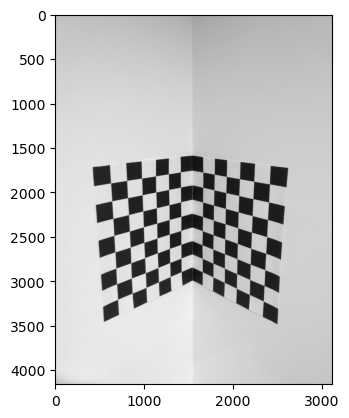

In [2]:
image = cv2.imread('calib-object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray,cmap="gray");

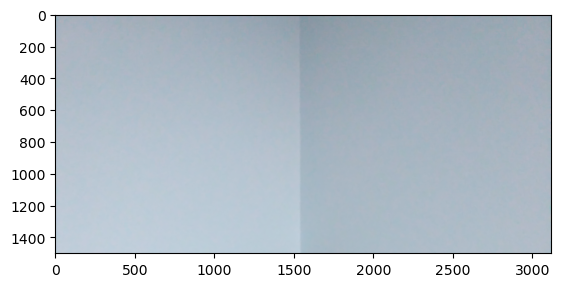

In [3]:
new_image = image[0:1500,:]
plt.imshow(new_image,cmap="gray");

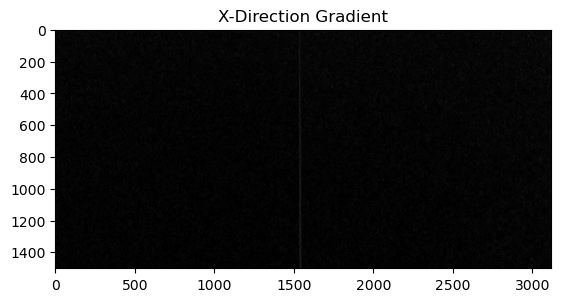

In [4]:
gradient_x = np.abs(cv2.Sobel(new_image, cv2.CV_64F, 1, 0, ksize=3))
plt.imshow(gradient_x[:,:,2],cmap="gray")
plt.title('X-Direction Gradient')
plt.show()

In [5]:
split_cord = np.argmax(gradient_x[:,:,0].sum(axis=0))

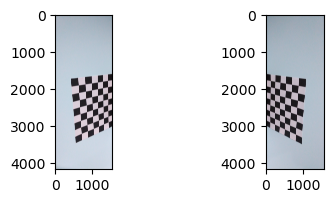

In [6]:
chess_left = image[:,:split_cord]
chess_right = image[:,split_cord:]
plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.imshow(chess_left,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(chess_right,cmap="gray");

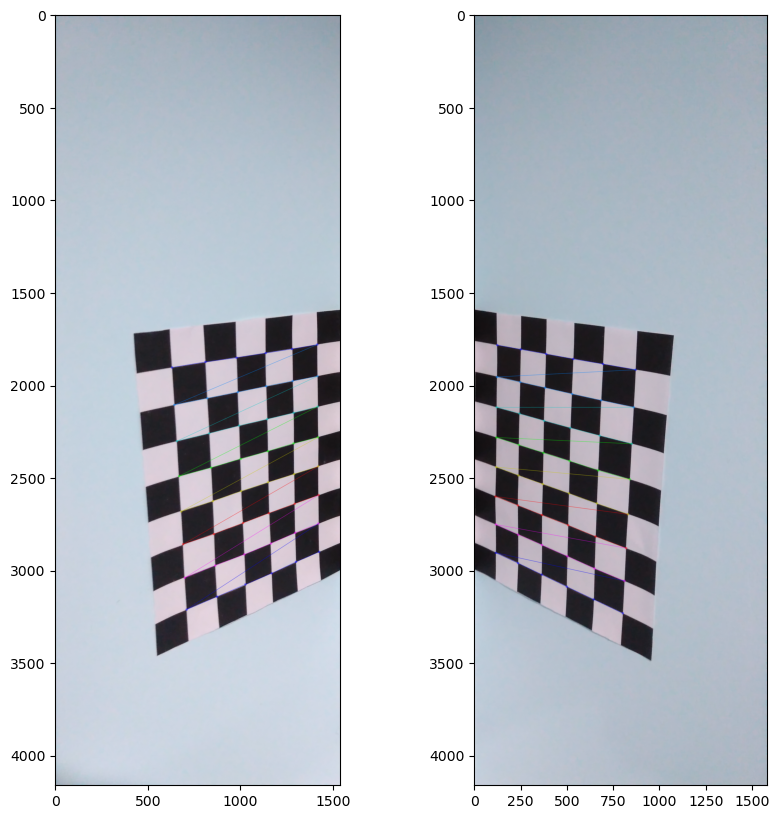

In [7]:
ret, corners_left = cv2.findChessboardCorners(chess_left, (6,8),None)
img1 = cv2.drawChessboardCorners(chess_left, (6,8), corners_left,ret)

ret, corners_right = cv2.findChessboardCorners(chess_right, (6,8),None)
img2 = cv2.drawChessboardCorners(chess_right, (6,8), corners_right,ret)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2);

In [8]:
print("The internal corners of the left chess board are ",len(corners_left))
print("The internal corners of the right chess board are ",len(corners_right))

The internal corners of the left chess board are  48
The internal corners of the right chess board are  48


##### Let's assume in chess_left_board the world co-ordinates of
 - top left  to be( 0,0,0),
 - bottom left to be 0,14,0 ,
 - top right to be (10,0,0),
 - bottom right to be (10,14,0)

In [9]:
corners = []
for corner in corners_left:
    temp= []
    temp.append(corner[0][0].astype(int))
    temp.append(corner[0][1].astype(int))
    corners.append(temp)
for corner in corners_right:
    temp= []
    temp.append(corner[0][0].astype(int) + split_cord)
    temp.append(corner[0][1].astype(int))
    corners.append(temp)

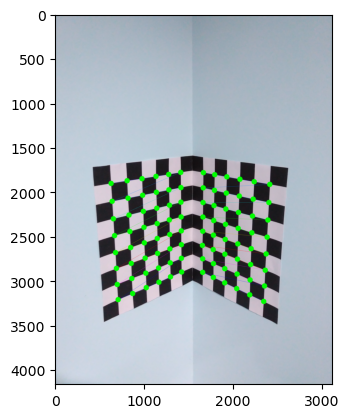

In [10]:
temp = np.copy(image)
for cord in corners:
    cv2.circle(temp ,(cord[0], cord[1]), 30, (0, 255, 0), -1)
plt.imshow(temp)
plt.show()

## b)

In [11]:
# Example correspondences [(X, Y, Z, u, v), ...]
correspondences = []
for j in range(8): 
    i=0
    temp = corners_left[6*j:6*(j+1)]
    for corner in temp:
        correspondences.append((2*i,2*(j),0,corner[0][0].astype(int),corner[0][1].astype(int)))
        i=i+1
len(correspondences),correspondences[0:7]

(48,
 [(0, 0, 0, 629, 1904),
  (2, 0, 0, 809, 1874),
  (4, 0, 0, 976, 1851),
  (6, 0, 0, 1133, 1825),
  (8, 0, 0, 1276, 1803),
  (10, 0, 0, 1411, 1780),
  (0, 2, 0, 641, 2105)])

In [12]:
cor_right=[]
for corner in corners_right:
    temp= []
    temp.append(corner[0][0].astype(int) + split_cord)
    temp.append(corner[0][1].astype(int))
    cor_right.append(temp)
# cor_right

In [13]:
# Example correspondences [(X, Y, Z, u, v), ...]
# correspondences = []
for j in range(8): 
    i=0
    temp = cor_right[6*j:6*(j+1)]
    for corner in temp:
        correspondences.append((12,2*(j),2*(i+1),corner[0].astype(int),corner[1].astype(int)))
        i=i+1
len(correspondences),correspondences[-7:]

(96,
 [(12, 12, 12, 2351, 3057),
  (12, 14, 2, 1657, 2904),
  (12, 14, 4, 1777, 2961),
  (12, 14, 6, 1904, 3022),
  (12, 14, 8, 2039, 3087),
  (12, 14, 10, 2185, 3157),
  (12, 14, 12, 2342, 3231)])

In [14]:
def dlt_calibration(correspondences):
    num_correspondences = len(correspondences)

    A = np.zeros((2 * num_correspondences, 12))

    for i in range(num_correspondences):
        X, Y, Z, u, v = correspondences[i]

        A[2*i] = [-X, -Y, -Z, -1, 0, 0, 0, 0, u*X, u*Y, u*Z, u]
        A[2*i + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, v*X, v*Y, v*Z, v]

    _, _, V = svd(A)
    print(V.shape)
    solution = V[-1, :]
    return solution.reshape((3,4))

In [15]:
P = dlt_calibration(correspondences)
M=P[:,0:3]
K, R = linalg.rq(M)
M= P[:,:3]
t = np.dot(np.linalg.inv(K), P[:,3])
P # projection Matric

(12, 12)


array([[ 5.21510232e-02,  4.94039298e-03,  2.06111656e-02,
         3.13579823e-01],
       [ 1.07049248e-02,  5.63999061e-02, -1.07666708e-02,
         9.46090389e-01],
       [ 9.50142215e-06,  3.12522904e-06, -9.81395356e-06,
         4.96648490e-04]])

In [16]:
# Print the results
print("Matrix K (Intrinsic Matrix):")
print(np.abs(K))
print("\nMatrix R(Extrinsic - Rotation Matrix):")
print(R)
print("\nMatrix t(Extrinsic - Translation Matrix):")
print(t)

Matrix K (Intrinsic Matrix):
[[5.18042055e-02 2.31089020e-04 2.20278854e-02]
 [0.00000000e+00 5.15938416e-02 2.73777562e-02]
 [0.00000000e+00 0.00000000e+00 1.40127715e-05]]

Matrix R(Extrinsic - Rotation Matrix):
[[ 0.71905584 -0.00381612  0.69494183]
 [ 0.15231827 -0.97480475 -0.16295654]
 [ 0.67805446  0.22302719 -0.70035778]]

Matrix t(Extrinsic - Translation Matrix):
[-9.01541128  0.46996642 35.44255981]


## c)

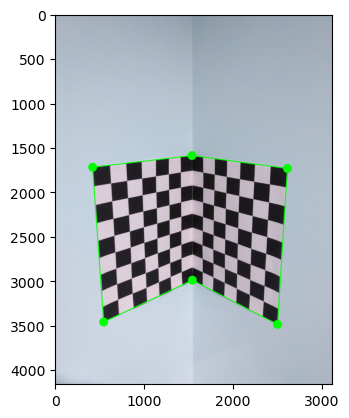

In [17]:
outer_corners_3d_homogeneous = np.array([[-2,-2,0,1],[12,-2,0,1],[12,-2,14,1],[12,16,14,1],[12,16,0,1],[-2,16,0,1]])  # Homogeneous coordinates of outer corners

outer_corners_2d_homogeneous = np.dot(P, outer_corners_3d_homogeneous.T).T

outer_corners_2d = outer_corners_2d_homogeneous[:, :2] / outer_corners_2d_homogeneous[:, 2:]

image = cv2.imread('calib-object.jpg')

# Overlay wireframe on the image
for i in range(outer_corners_2d.shape[0]):
    cv2.circle(image, tuple(outer_corners_2d[i].astype(int)), 50, (0, 255, 0), -1)

for i in range(outer_corners_2d.shape[0] - 1):
    cv2.line(image, tuple(outer_corners_2d[i].astype(int)), tuple(outer_corners_2d[i + 1].astype(int)), (0, 255, 0), 10)
    
cv2.line(image, tuple(outer_corners_2d[-1].astype(int)), tuple(outer_corners_2d[0].astype(int)), (0, 255, 0), 10)
plt.imshow(image);

 - The calibration process accurately estimated the camera's intrinsic and extrinsic parameters, leading to precise mapping between the 3D world coordinates and 2D image coordinates.
 
 - The alignment of the wireframe with the actual chessboard corners suggests that the distortion correction and camera parameter estimation were effective.


## D)

In [18]:
def rotation_matrix_to_euler_angles(rotation_matrix):
    # Extract individual elements from the rotation matrix
    r00, r01, r02 = rotation_matrix[0, 0], rotation_matrix[0, 1], rotation_matrix[0, 2]
    r10, r11, r12 = rotation_matrix[1, 0], rotation_matrix[1, 1], rotation_matrix[1, 2]
    r20, r21, r22 = rotation_matrix[2, 0], rotation_matrix[2, 1], rotation_matrix[2, 2]

    # Calculate roll (phi), pitch (theta), and yaw (psi) angles
    roll_x = np.arctan2(r21, r22) # x
    pitch_y = np.arctan2(-r20, np.sqrt(r21**2 + r22**2)) # y
    yaw_z = np.arctan2(r10, r00) # z

    # Convert angles to degrees for easier interpretation
    roll_x = np.degrees(roll_x)
    pitch_y = np.degrees(pitch_y)
    yaw_z = np.degrees(yaw_z)

    return roll_x, pitch_y, yaw_z

In [19]:
roll, pitch, yaw = rotation_matrix_to_euler_angles(R)

print(f"Roll (phi) x-axis: {roll} degrees")
print(f"Pitch (theta) y-axis: {pitch} degrees")
print(f"Yaw (psi) z-axis: {yaw} degrees")


Roll (phi) x-axis: 162.3360535035248 degrees
Pitch (theta) y-axis: -42.691797935348596 degrees
Yaw (psi) z-axis: 11.960216190303727 degrees


 - The rotation matrix can be decomposed into three Euler angles: pitch (tilt), yaw (pan), and roll.

 - Pitch corresponds to rotation around the x-axis.
 - Roll corresponds to rotation around the y-axis.
 - Yaw corresponds to rotation around the z-axis.

 - Pan: Rotation horizontally around the vertical axis (y-axis), involving turning from side to side.

 - Tilt: Rotation vertically around the horizontal axis (x-axis), involving tipping up or down.

 - Roll: Rotation around the longitudinal axis (z-axis), involving a side-to-side motion, often associated with the optical axis or line of sight.

# Q2

## a)

In [20]:
obj_points=[]
img_points = []
for temp in correspondences[:48]:
    x1,x2,x3,x4,x5 = temp
    obj_points.append([x1,x2,x3])
    img_points.append([x4,x5])
obj_points = np.array(obj_points).astype(np.float32)
img_points = np.array(img_points).astype(np.float32)

In [21]:
(chess_left.shape[:2])[::-1]

(1540, 4160)

In [22]:
# Inital Estimate considering only a plane ( Z=0)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([obj_points], [img_points], (chess_left.shape[:2])[::-1], None, None)

In [23]:
obj_points=[]
img_points = []
for temp in correspondences:
    x1,x2,x3,x4,x5 = temp
    obj_points.append([x1,x2,x3])
    img_points.append([x4,x5])
obj_points = np.array(obj_points).astype(np.float32)
img_points = np.array(img_points).astype(np.float32)

In [24]:
# Now, use the obtained mtx as the initial guess for the intrinsic matrix
# Calibrate camera with initial guess with entire 3D Object
# cameraMatrix,rotMatrix,transVect,_,_,_,_ = cv2.decomposeProjectionMatrix(P)
ret, K_cv, dist, R_cv, t_cv = cv2.calibrateCamera([obj_points], [img_points], gray.shape[::-1], mtx, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
imgpoints2, _ = cv2.projectPoints(obj_points,R_cv[0],t_cv[0], K_cv, dist)

# frame_points = np.array([[-2,-2,0],[12,-2,0],[12,-2,14],[12,16,14],[12,16,0],[-2,16,0]])
frame_points = np.array([[-2, -2, 0], [12, -2, 0], [12, -2, 14], [12, 16, 14], [12, 16, 0], [-2, 16, 0]], dtype=np.float32)

imgpoints3, _ = cv2.projectPoints(frame_points,R_cv[0],t_cv[0], K_cv, dist)

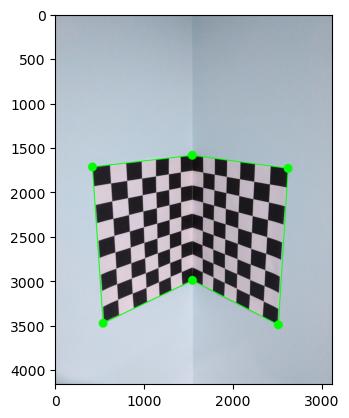

In [25]:
outer_corners_2d= imgpoints3
image = cv2.imread('calib-object.jpg')

for i in range(outer_corners_2d.shape[0]):
    cv2.circle(image, tuple(outer_corners_2d[i][0].astype(int)), 50, (0, 255, 0), -1)

for i in range(outer_corners_2d.shape[0] - 1):
    cv2.line(image, tuple(outer_corners_2d[i][0].astype(int)), tuple(outer_corners_2d[i + 1][0].astype(int)), (0, 255, 0), 10)
    
cv2.line(image, tuple(outer_corners_2d[-1][0].astype(int)), tuple(outer_corners_2d[0][0].astype(int)), (0, 255, 0), 10)
plt.imshow(image);

- The OpenCV calibration process provides results comparable to the manual calibration in Q1.

 - The intrinsic and extrinsic parameters, including the camera matrix, are estimated by OpenCV's calibrateCamera() function.

 - Overlaying the wireframe using the new parameters should resulted in a good match, as OpenCV's calibration is robust  minimize the errors.
 
 - The overlay is identical to the manually calibrated version, affirming the accuracy of OpenCV's calibration.

## b)

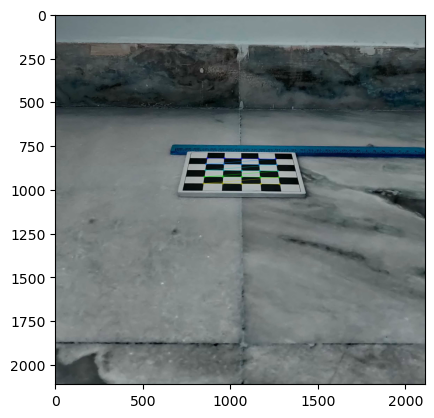

In [26]:
img = cv2.imread('./assign1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (5, 5), None)

if ret:
    cv2.drawChessboardCorners(img, (5, 5), corners, ret)
plt.imshow(img);

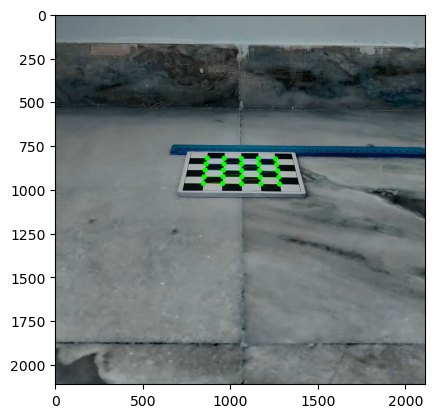

In [27]:
temp = np.copy(img)
for cord in corners:
    cv2.circle(temp ,(cord[0][0].astype(int), cord[0][1].astype(int)), 15, (0, 255, 0), -1)
plt.imshow(temp)
plt.show()

In [28]:
# Example correspondences [(X, Y, Z, u, v), ...]
correspondences = []
for j in range(5): 
    i=0
    temp = corners[5*j:5*(j+1)]
    for corner in temp:
        # print(corner)
        correspondences.append((j*2,2*(i),0,corner[0][0].astype(int),corner[0][1].astype(int)))
        i=i+1
len(correspondences),correspondences[0:6]

(25,
 [(0, 0, 0, 869, 823),
  (0, 2, 0, 966, 823),
  (0, 4, 0, 1064, 825),
  (0, 6, 0, 1161, 825),
  (0, 8, 0, 1259, 827),
  (2, 0, 0, 862, 856)])

In [29]:
obj_points=[]
img_points = []
for temp in correspondences:
    x1,x2,x3,x4,x5 = temp
    obj_points.append([x1,x2,x3])
    img_points.append([x4,x5])
obj_points = np.array(obj_points).astype(np.float32)
img_points = np.array(img_points).astype(np.float32)

In [30]:
ret, K_cv, dist, R_cv, t_cv= cv2.calibrateCamera([obj_points], [img_points], gray.shape[::-1], None, None)

In [31]:
frame_points = np.array([[-2, -2, 0], [10, -2, 0], [10,10, 0], [-2, 10, 0]], dtype=np.float32)
imgpoints2, _ = cv2.projectPoints(frame_points,R_cv[0],t_cv[0], K_cv, dist)

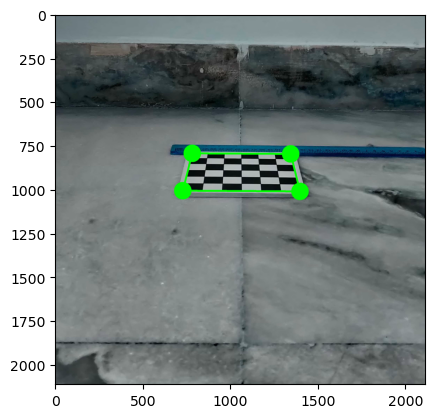

In [32]:
outer_corners_2d= imgpoints2
image = cv2.imread('assign1.jpg')

for i in range(outer_corners_2d.shape[0]):
    cv2.circle(image, tuple(outer_corners_2d[i][0].astype(int)), 50, (0, 255, 0), -1)

for i in range(outer_corners_2d.shape[0] - 1):
    cv2.line(image, tuple(outer_corners_2d[i][0].astype(int)), tuple(outer_corners_2d[i + 1][0].astype(int)), (0, 255, 0), 10)
    
cv2.line(image, tuple(outer_corners_2d[-1][0].astype(int)), tuple(outer_corners_2d[0][0].astype(int)), (0, 255, 0), 10)
plt.imshow(image);
original_image = np.copy(image)

In [33]:
before_cord = np.copy(outer_corners_2d)

- In my observations, while calibrating assign1.jpg, the wireframe overlay displayed notable distortions, underscoring the challenges posed by coplanarity;

-  however, the intrinsic matrix proved less critical in this scenario, as the projection matrix could be computed directly to address these specific calibration complexities in two-view geometry.


### C) What is the image of the world origin, given the calibration matrix?

 - The image of the world origin can be computed by projecting the world origin (0, 0, 0) using the calibration matrix.

 
 - **Observations:** The image of the world origin is ideally be near the image center, reflecting the position of the camera in relation to the world origin.

# Q3)

In [34]:
frame_points = np.array([[8, -2, 0], [18, -2, 0], [18,10, 0], [8, 10, 0]], dtype=np.float32)
imgpoints2, _ = cv2.projectPoints(frame_points,R_cv[0],t_cv[0], K_cv, dist)

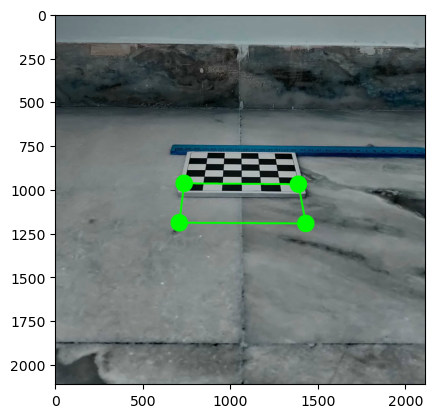

In [35]:
outer_corners_2d= imgpoints2
image = cv2.imread('assign1.jpg')

for i in range(outer_corners_2d.shape[0]):
    cv2.circle(image, tuple(outer_corners_2d[i][0].astype(int)), 50, (0, 255, 0), -1)

for i in range(outer_corners_2d.shape[0] - 1):
    cv2.line(image, tuple(outer_corners_2d[i][0].astype(int)), tuple(outer_corners_2d[i + 1][0].astype(int)), (0, 255, 0), 10)
    
cv2.line(image, tuple(outer_corners_2d[-1][0].astype(int)), tuple(outer_corners_2d[0][0].astype(int)), (0, 255, 0), 10)
plt.imshow(image);
shifted_wireframe = np.copy(image)

 - Co-planar points in the world coordinate system had lead to challenges in calibration. When trying to calibrate based on co-planar points, the calibration problem became ill-conditioned.

 - Ill-conditioned calibration problems resulted in distortions in the wireframe overlay, especially as the co-planar points are not well-distributed.

 - Observations: The wireframe overlay shows significant distortions, it suggests that the calibration process for assign1.jpg faced challenges due to co-planar points. In two-view geometry, co-planar points have lead to degenerate cases in the calibration, affecting the accuracy of the computed projection matrix.

In [36]:
after_cord =np.copy(outer_corners_2d) 

In [37]:
before_cord = before_cord.astype(int)
after_cord = after_cord.astype(int)

In [38]:
poly1=[]
for cord in before_cord:
    poly1.append([cord[0][0],cord[0][1]])
poly2=[]
for cord in after_cord:
    poly2.append([cord[0][0],cord[0][1]])
    # print(cord[0])

In [39]:
poly2

[[737, 966], [709, 1191], [1431, 1195], [1389, 971]]

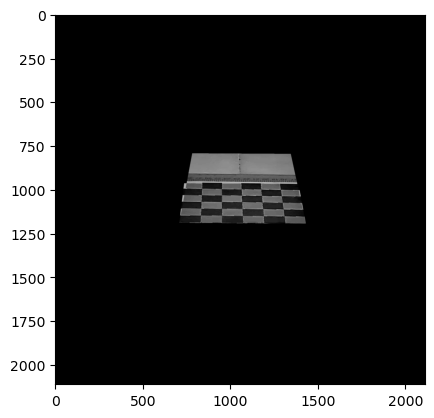

In [40]:
src_points = np.array(poly1, dtype=np.float32)
dst_points = np.array(poly2, dtype=np.float32)

input_image = cv2.imread('assign1.jpg')

# Step 1: Perform Perspective Transformation
transformation_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
transformed_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transformed_image = cv2.warpPerspective(transformed_image, transformation_matrix, (transformed_image.shape[1], transformed_image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

# Step 2: Create a Mask for a Rectangle
rectangle_corners = [src_points[0], dst_points[1], dst_points[2], src_points[3]]
rectangle_mask = np.zeros_like(transformed_image, dtype=np.uint8)  # Ensure the mask has the same type as the images
cv2.fillPoly(rectangle_mask, [np.array(rectangle_corners, dtype=np.int32)], 255)
masked_result = cv2.bitwise_and(transformed_image, transformed_image, mask=rectangle_mask)

# Step 3: Create a Mask for a Quadrilateral
quadrilateral_mask = np.zeros_like(transformed_image)
cv2.fillPoly(quadrilateral_mask, [np.array(dst_points, dtype=np.int32)], 255)
result = cv2.bitwise_and(transformed_image, transformed_image, mask=quadrilateral_mask)

combined_result = (result + masked_result) % 256

plt.imshow(combined_result, cmap='gray')
plt.show()

transformed_pattern = np.copy(combined_result)

In [41]:
input_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
result = cv2.bitwise_or(combined_result.astype(np.uint8), input_gray)
final_result = (combined_result*0.5+0.5*input_gray)

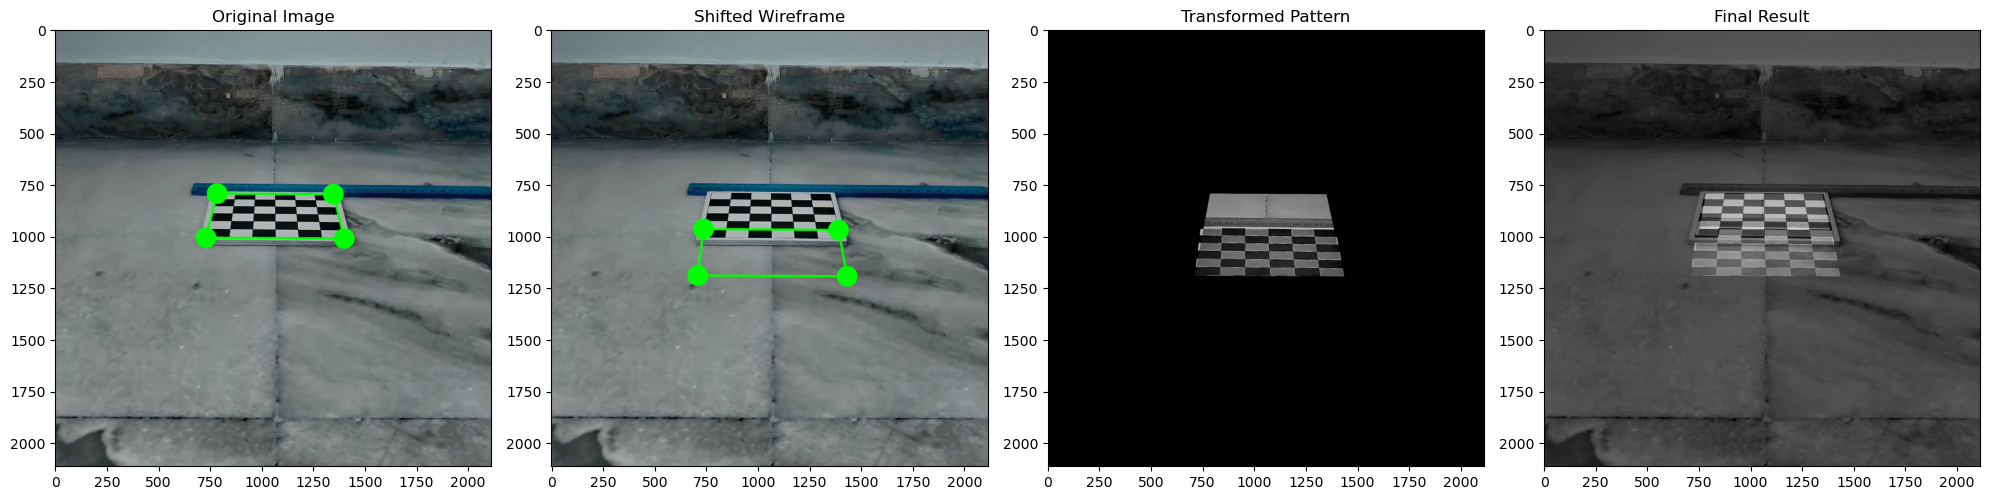

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(shifted_wireframe)
plt.title('Shifted Wireframe')

plt.subplot(1, 4, 3)
plt.imshow(transformed_pattern, cmap='gray')
plt.title('Transformed Pattern')

plt.subplot(1, 4, 4)
plt.imshow(final_result, cmap='gray')
plt.title('Final Result')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

- We would expect the chess board to move 10 cm to the right but we see that it is appearing to be moving toward us